In [1]:
import torch
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_features = torch.tensor([], dtype=torch.float)
train_labels = torch.tensor([], dtype=torch.int)

for i in tqdm(range(1, 61), desc='Loading Train Data', total=60):
    loaded_tensors = torch.load(f'/kaggle/input/imagenet-1k-embeddings-data/trainset_{i}.pth', weights_only=True)
    train_features = torch.cat((train_features, loaded_tensors['trainset_features']), axis=0)
    train_labels = torch.cat((train_labels, loaded_tensors['trainset_labels']), axis=0)

train_indices = torch.randperm(train_features.shape[0])[:120000]
train_features = train_features[train_indices]
train_labels = train_labels[train_indices]

test_features = torch.tensor([], dtype=torch.float)
test_labels = torch.tensor([], dtype=torch.int)

for i in tqdm(range(1, 4), desc='Loading Test Data', total=3):
    loaded_tensors = torch.load(f'/kaggle/input/imagenet-1k-embeddings-data/testset_{i}.pth', weights_only=True)
    test_features = torch.cat((test_features, loaded_tensors['testset_features']), axis=0)
    test_labels = torch.cat((test_labels, loaded_tensors['testset_labels']), axis=0)


test_indices = torch.randperm(test_features.shape[0])[:20000]
test_features = test_features[test_indices]
test_labels = test_labels[test_indices]


num_labels = 1000

print (train_features.shape)
print (train_labels.shape)
print (test_features.shape)
print (test_labels.shape)

Loading Test Data: 100%|██████████| 3/3 [00:05<00:00,  1.75s/it]

torch.Size([120000, 2048])
torch.Size([120000])
torch.Size([20000, 2048])
torch.Size([20000])


In [2]:
train_features = train_features.numpy()
train_labels = train_labels.numpy()
test_features = test_features.numpy()
test_labels = test_labels.numpy()

In [3]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def get_top_k_matches(train_features, test_features, train_indices, k=50):
    if len(train_indices) == 0:
        return np.array([[] for _ in test_features])

    # Get the features of images belonging to the same cluster
    cluster_features = train_features[train_indices]

    # Compute cosine similarity between the test image and cluster images
    similarities = cosine_similarity(test_features, cluster_features)
    
    # Get the top k most similar images
    top_k_indices = np.argsort(similarities, axis=1)[:, ::-1][:, :k]
    return train_indices[top_k_indices]


In [4]:
def precision_at_k(true_label, top_k_labels, k):
    top_k = top_k_labels[:k]
    correct = np.sum(top_k == true_label)
    return correct / k

def mean_average_precision(true_label, top_k_labels):
    # Calculate precision at each rank and then compute average precision
    precisions = []
    correct = 0
    for i, label in enumerate(top_k_labels):
        if label == true_label:
            correct += 1
            precisions.append(correct / (i + 1))
    return np.mean(precisions) if precisions else 0


In [5]:
import numpy as np

!pip install faiss-gpu
!pip install faiss-cpu

import faiss

def create_clusters(train_features, test_features, num_clusters):
    # Convert to float32 as required by Faiss
    train_features = train_features.astype(np.float32)
    test_features = test_features.astype(np.float32)

    # Initialize the Faiss KMeans object (d = dimensionality of data)
    kmeans = faiss.Kmeans(d=train_features.shape[1], k=num_clusters, niter=200, gpu=True, verbose=False)

    # Train K-Means on the training set
    kmeans.train(train_features)

    # Get the cluster assignments for the training data
    _, train_clusters = kmeans.index.search(train_features, 1)  # 1 nearest cluster
    train_clusters = train_clusters.flatten()  # Flatten to a 1D array

    # Create a dictionary mapping cluster indices to data points
    train_clusters_dict = {}
    for cluster in range(num_clusters):
        train_clusters_dict[cluster] = np.where(train_clusters == cluster)[0]

    # Assign each test image to its nearest cluster
    _, test_clusters = kmeans.index.search(test_features, 1)  # 1 nearest cluster
    test_clusters = test_clusters.flatten()  # Flatten to a 1D array

    return train_clusters_dict, test_clusters

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 59.4 MB/s eta 0:00:00


In [6]:
def get_top_matches(train_features, test_features, num_clusters, k=50):
    train_clusters_dict, test_clusters = create_clusters(train_features, test_features, num_clusters)
    # For each test image, find the top 50 matches
    top_k_matches = [np.array([]) for _ in range(len(test_features))]
    for cluster_num in range(num_clusters):
        mask = (test_clusters == cluster_num)
        mask_indices = np.nonzero(mask)[0]
        if (len(mask_indices) == 0):
            continue
        matches = get_top_k_matches(train_features, test_features[mask], train_clusters_dict[cluster_num])
        for i, idx in enumerate(mask_indices):
            top_k_matches[idx] = matches[i]

    return top_k_matches

In [7]:
def evaluate(train_labels, test_labels, top_k_matches):
    # Evaluate for all test images
    precision_10 = []
    precision_50 = []
    mean_ap = []
    for i, matches in enumerate(top_k_matches):
        true_label = test_labels[i]
        matched_labels = train_labels[matches]

        precision_10.append(precision_at_k(true_label, matched_labels, 10))
        precision_50.append(precision_at_k(true_label, matched_labels, 50))
        mean_ap.append(mean_average_precision(true_label, matched_labels))

    return np.mean(precision_10), np.mean(precision_50), np.mean(mean_ap)

In [8]:
def run(train_features, train_labels, test_features, test_labels, num_clusters):
    top_k_matches = get_top_matches(train_features, test_features, num_clusters)
    return evaluate(train_labels, test_labels, top_k_matches)

Processing Num Clusters:: 100%|██████████| 20/20 [08:59<00:00, 26.96s/it]


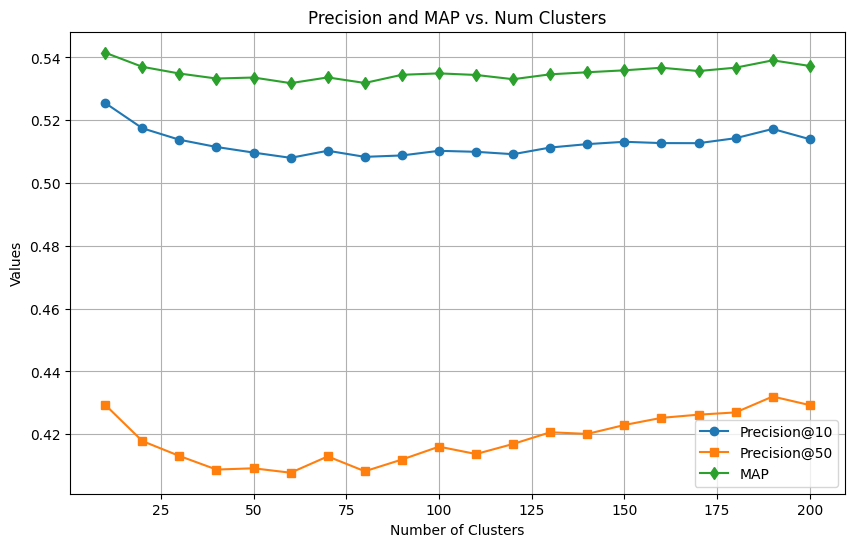

In [9]:
num_clusters_list = list(range(10, 201, 10))
prec_10_list = []
prec_50_list = []
map_list = []

for num_clusters in tqdm(num_clusters_list, desc='Processing Num Clusters:', total=len(num_clusters_list)):
    prec_10, prec_50, map_value = run(train_features, train_labels, test_features, test_labels, num_clusters)

    prec_10_list.append(prec_10)
    prec_50_list.append(prec_50)
    map_list.append(map_value)

import matplotlib.pyplot as plt

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_clusters_list, prec_10_list, marker='o', label='Precision@10')
plt.plot(num_clusters_list, prec_50_list, marker='s', label='Precision@50')
plt.plot(num_clusters_list, map_list, marker='d', label='MAP')

# Adding titles and labels
plt.title('Precision and MAP vs. Num Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

plt.savefig('variation_with_num_clusters.png', dpi=300)
# Show the plot
plt.show()

Processing Num Components (PCA):: 100%|██████████| 20/20 [13:30<00:00, 40.50s/it]


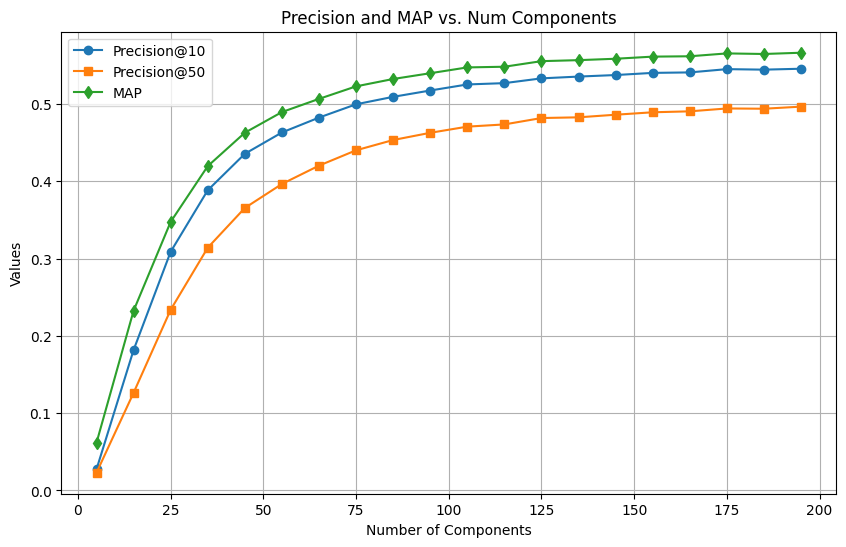

In [10]:
from sklearn.decomposition import PCA

num_components_list = list(range(5, 201, 10))
prec_10_list = []
prec_50_list = []
map_list = []

for num_components in tqdm(num_components_list, desc='Processing Num Components (PCA):', total=len(num_components_list)):
    pca = PCA(n_components=num_components)
    train_features_pca = pca.fit_transform(train_features)
    test_features_pca = pca.transform(test_features)

    prec_10, prec_50, map_value = run(train_features_pca, train_labels, test_features_pca, test_labels, num_labels)

    prec_10_list.append(prec_10)
    prec_50_list.append(prec_50)
    map_list.append(map_value)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(num_components_list, prec_10_list, marker='o', label='Precision@10')
plt.plot(num_components_list, prec_50_list, marker='s', label='Precision@50')
plt.plot(num_components_list, map_list, marker='d', label='MAP')

# Adding titles and labels
plt.title('Precision and MAP vs. Num Components')
plt.xlabel('Number of Components')
plt.ylabel('Values')
plt.legend()
plt.grid(True)

plt.savefig('variation_with_num_components_pca.png', dpi=300)
# Show the plot
plt.show()